### Pre-process step 1
- This pre processing step first rotates the full frame to flatten the spectrum using rotationsl transformation
- Following rotation, the image is affine transformed to straighten the skew in the slit due to the prism
- Needs: Calibration sequence
    - Acquire calibration sequence after any modifications to the system or at the start of every month if no modifications are made
    - Turn on all lasers and acquire a short sequence at full frame


In [1]:
import pandas as pd
import numpy as np
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
from natsort import natsorted
from skimage import io
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import cv2 as cv

Paths are for dataset tagged: all


['D:\\AIND\\output_data\\BigTiffs_2023-01-18T10_05_42.1850112-08_00\\metadata_2023-01-18T10_05_42.csv']
['Tiffs0.tif' 'Tiffs1.tif' 'Tiffs2.tif']
(1000, 2048, 2048)
(2048, 2048)


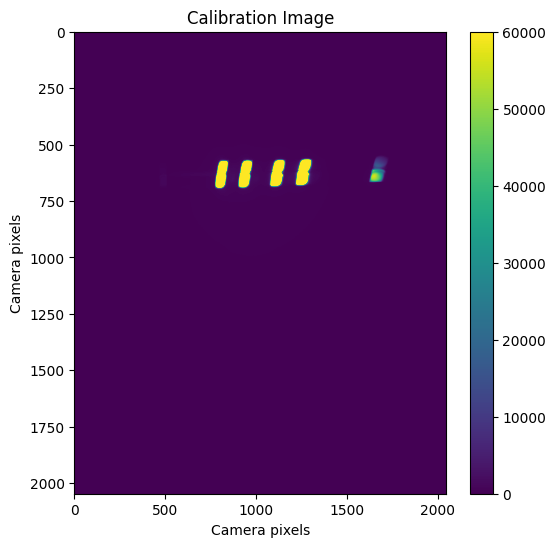

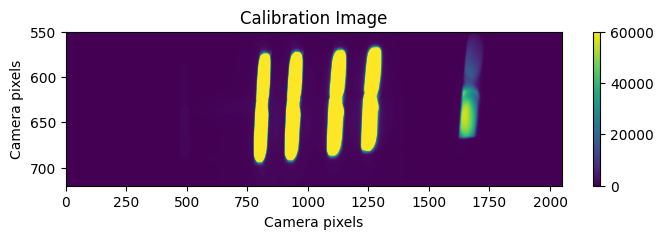

In [2]:
# Load calibration sequence images and metadata
path = paths['calibration_data']
metadata_file = glob.glob(os.path.join(path,'*.csv'))
print(metadata_file)
metadata = pd.read_csv(metadata_file[0])
files = os.listdir(path)
tiff_dir = os.path.join(path,files[1])
tiff_files = os.listdir(tiff_dir)
tiff_files = np.array(natsorted(tiff_files))
print(tiff_files)
tiff_file_path = os.path.join(tiff_dir,tiff_files[0])
img = io.imread(tiff_file_path)
print(img.shape)
# Average all frames 
img2d = img.mean(axis=0)
print(img2d.shape)

img_to_unskew = np.array(img2d)
f,ax = plt.subplots(figsize=(6,6))
i = ax.imshow(img_to_unskew, aspect='auto', vmin=0, vmax=60000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Calibration Image')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(8,2))
i = ax.imshow(img_to_unskew, aspect='auto', vmin=0, vmax=60000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Calibration Image', xlim=[0,2048], ylim=[720,550])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

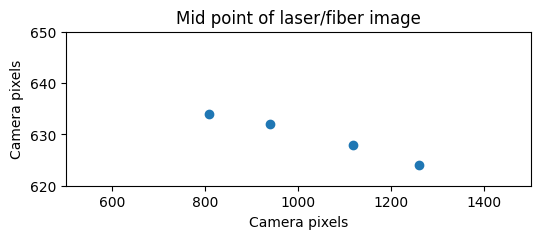

-1.1088121277599294


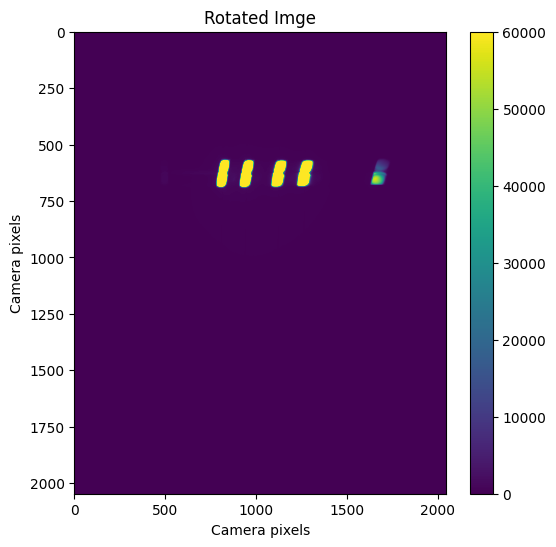

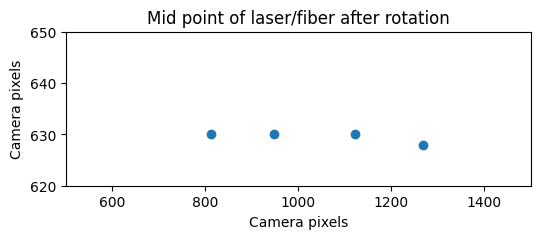

[ 813  949 1123 1269]
[630 630 630 628]


In [3]:
# Extract rotation of image to flatten spectrum
h_line = np.mean(img_to_unskew,axis=0)
h_laser_pix, _ = find_peaks(h_line, height=2000, distance=100)
count = 0
v_laser_pix = np.zeros(np.size(h_laser_pix))
for l in h_laser_pix:
    v_line = img_to_unskew[:,l]
    v_line[v_line<60000] = 0
    idx = np.nonzero(np.diff(v_line))[0]
    v_laser_pix[count] = np.round((idx[0]+idx[-1])/2)
    count +=1

f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_laser_pix,v_laser_pix,'o')
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Mid point of laser/fiber image', xlim=[500,1500],ylim=[620,650])
plt.show()

# Angle to rotate
theta_r = np.rad2deg(np.arctan((v_laser_pix[-2]-v_laser_pix[0])/(h_laser_pix[-2]-h_laser_pix[0])))
print(theta_r)

# Rotation using openCV
rows,cols = img_to_unskew.shape
M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),theta_r,1)
img_rotated = cv.warpAffine(img_to_unskew,M,(cols,rows))
img_rotated.shape
f,ax = plt.subplots(figsize=(6,6))
i = ax.imshow(img_rotated, aspect='auto', vmin=0, vmax=60000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Rotated Imge')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

# Check position of lasers in rotated image
h_line = np.mean(img_rotated,axis=0)
h_laser_pix, _ = find_peaks(h_line, height=2000, distance=100)
count = 0
v_laser_pix = np.zeros(np.size(h_laser_pix))
for l in h_laser_pix:
    v_line = img_rotated[:,l]
    v_line[v_line<60000] = 0
    idx = np.nonzero(np.diff(v_line))[0]
    v_laser_pix[count] = np.round((idx[0]+idx[-1])/2)
    count +=1
v_laser_pix = v_laser_pix.astype(int)
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_laser_pix,v_laser_pix,'o')
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Mid point of laser/fiber after rotation', xlim=[500,1500],ylim=[620,650])
plt.show()
print(h_laser_pix)
print(v_laser_pix)


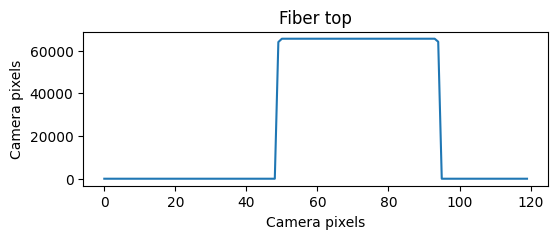

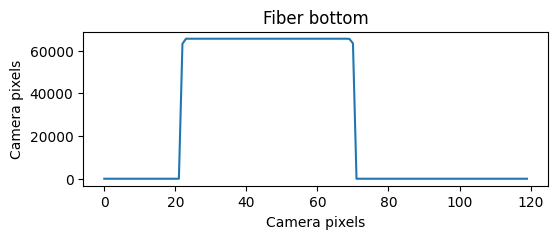

[572, 687]
[937, 910]


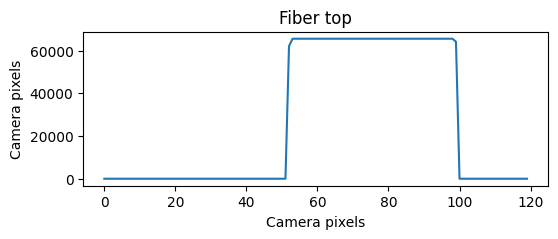

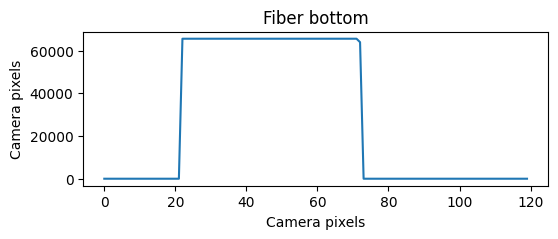

[573, 686]
[1114, 1084]


In [4]:
# Extract rotation of slit to straighten the spectrum
use_laser = 1

# Calculate the y-coordinates
v_line = img_rotated[:,h_laser_pix[use_laser]]
v_line[v_line<60000] = 0
idx = np.nonzero(np.diff(v_line))[0]
v_width = [idx[0],idx[-1]]

# Calculate the x-coordinates
h_line_top = img_rotated[v_width[0]+5,h_laser_pix[use_laser]-60:h_laser_pix[use_laser]+60]
h_line_top[h_line_top<60000] = 0
h_line_top_width = np.nonzero(np.diff(h_line_top))[0]
h_top = h_line_top_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_top)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber top')
plt.show()

h_line_bot = img_rotated[v_width[1]-5,h_laser_pix[use_laser]-60:h_laser_pix[use_laser]+60]
h_line_bot[h_line_bot<60000] = 0
h_line_bot_width = np.nonzero(np.diff(h_line_bot))[0]
h_bot = h_line_bot_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_bot)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber bottom')
plt.show()
h_width = [h_laser_pix[use_laser]-60+h_top, h_laser_pix[use_laser]-60+h_bot]

print(v_width)
print(h_width)

use_laser = 2
# Calculate the y-coordinates
v_line = img_rotated[:,h_laser_pix[use_laser]]
v_line[v_line<60000] = 0
idx = np.nonzero(np.diff(v_line))[0]
v_width2 = [idx[0],idx[-1]]

# Calculate the x-coordinates
h_line_top = img_rotated[v_width2[0]+5,h_laser_pix[use_laser]-60:h_laser_pix[use_laser]+60]
h_line_top[h_line_top<60000] = 0
h_line_top_width = np.nonzero(np.diff(h_line_top))[0]
h_top = h_line_top_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_top)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber top')
plt.show()

h_line_bot = img_rotated[v_width2[1]-5,h_laser_pix[use_laser]-60:h_laser_pix[use_laser]+60]
h_line_bot[h_line_bot<60000] = 0
h_line_bot_width = np.nonzero(np.diff(h_line_bot))[0]
h_bot = h_line_bot_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_bot)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber bottom')
plt.show()
h_width2 = [h_laser_pix[use_laser]-60+h_top, h_laser_pix[use_laser]-60+h_bot]

print(v_width2)
print(h_width2)

[937, 573] [910, 685] [1114, 573] [910, 573] [910, 685] [1084, 573]


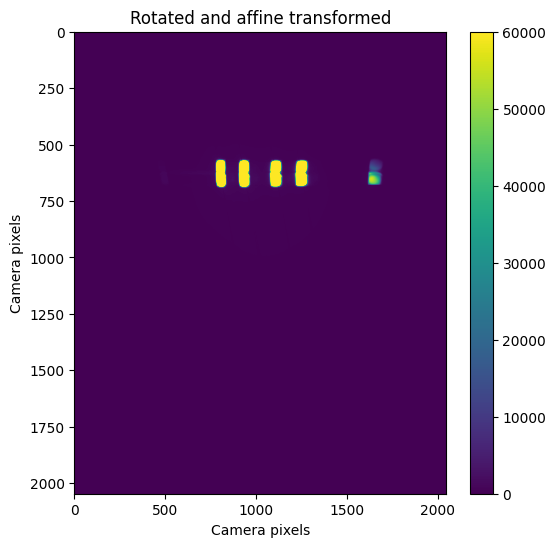

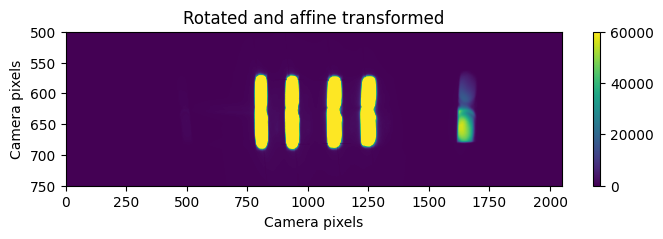

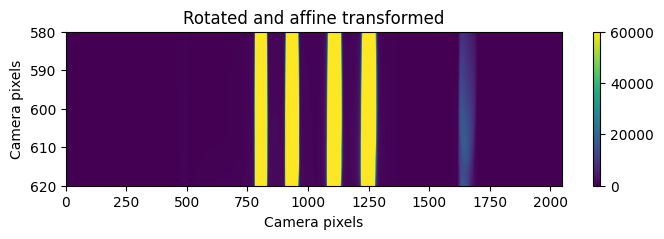

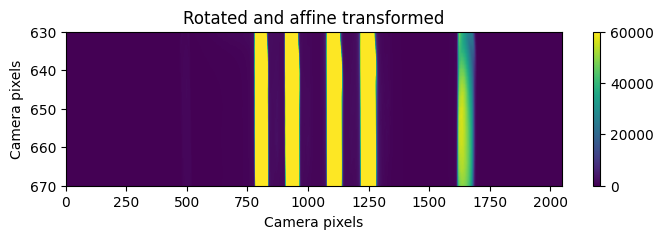

In [11]:
# Affine transformation
pt1 = [h_width[0], v_width[0]]
pt2 = [h_width[1], v_width[1]]
pt3 = [h_width2[0], v_width2[0]]
pt4 = [h_width[1], v_width[0]]
pt5 = [h_width[1], v_width[1]]
pt6 = [h_width2[1], v_width2[0]]
print(pt1,pt2, pt3, pt4, pt5, pt6)

rows,cols = img_rotated.shape
pts1 = np.float32([pt1, pt2, pt3])
pts2 = np.float32([pt4, pt5, pt6])
M = cv.getAffineTransform(pts1,pts2)
img_final = cv.warpAffine(img_rotated,M,(cols,rows))

f,ax = plt.subplots(figsize=(6,6))
i = ax.imshow(img_final, aspect='auto', vmin=0, vmax=60000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Rotated and affine transformed')
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(8,2))
i = ax.imshow(img_final, aspect='auto', vmin=0, vmax=60000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels',  title='Rotated and affine transformed', xlim=[0,2048], ylim=[750,500])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

# Fiber 1 location
f,ax = plt.subplots(figsize=(8,2))
i = ax.imshow(img_final, aspect='auto', vmin=0, vmax=60000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels',  title='Rotated and affine transformed', xlim=[0,2048], ylim=[620,580])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

# Fiber 2 location
f,ax = plt.subplots(figsize=(8,2))
i = ax.imshow(img_final, aspect='auto', vmin=0, vmax=60000)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels',  title='Rotated and affine transformed', xlim=[0,2048], ylim=[670,630])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

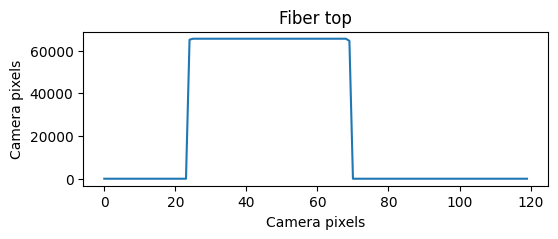

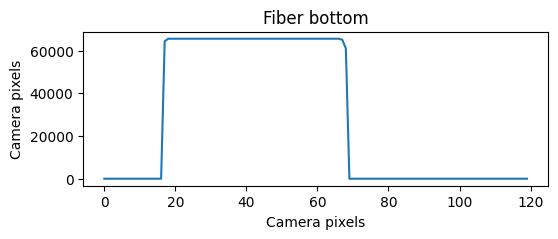

In [6]:
# Check laser top and bottom after affine transformation
use_laser = 2
# Calculate the y-coordinates
v_line = img_final[:,h_laser_pix[use_laser]]
v_line[v_line<60000] = 0
idx = np.nonzero(np.diff(v_line))[0]
v_width = [idx[0],idx[-1]]
# Calculate the x-coordinates
h_line_top = img_final[v_width[0]+5,h_laser_pix[use_laser]-60:h_laser_pix[use_laser]+60]
h_line_top[h_line_top<60000] = 0
h_line_top_width = np.nonzero(np.diff(h_line_top))[0]
h_top = h_line_top_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_top)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber top')
plt.show()
h_line_bot = img_final[v_width[1]-5,h_laser_pix[use_laser]-60:h_laser_pix[use_laser]+60]
h_line_bot[h_line_bot<60000] = 0
h_line_bot_width = np.nonzero(np.diff(h_line_bot))[0]
h_bot = h_line_bot_width[0]
f, ax = plt.subplots(figsize=(6,2))
ax.plot(h_line_bot)
ax.set(xlabel='Camera pixels', ylabel='Camera pixels', title='Fiber bottom')
plt.show()

In [7]:
# Save transformed image for wavelength calibration
img_final = img_final.astype(int)
cv.imwrite('wavelengthCalibrationImage.tif',img_final)

True